C:\Users\shrey\AppData\Local\Temp\ipykernel_1036\3952124403.py:9: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
C:\Users\shrey\AppData\Local\Temp\ipykernel_1036\3952124403.py:9: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
C:\Users\shrey\AppData\Local\Temp\ipykernel_1036\3952124403.py:9: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


52507


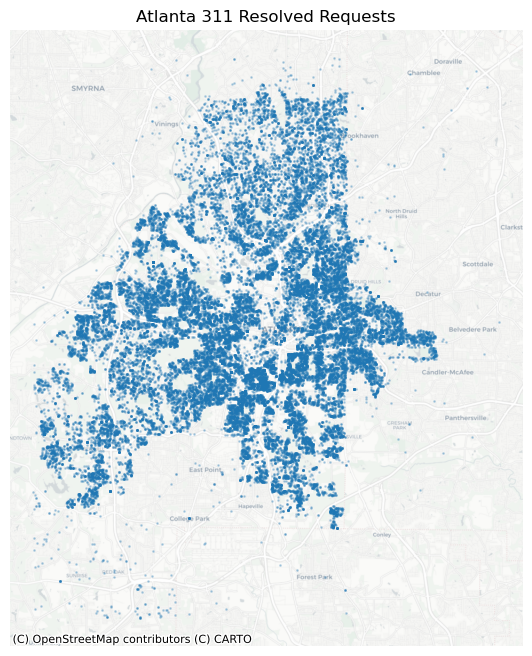

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# -----------------------------
# 1. Read cleaned geocoded CSV
# -----------------------------
df = pd.read_csv(
    "../data/cleaned_data/atl311_2022_merged_with_geocodes.csv",
    parse_dates=["Opened", "Closed Date 1", "Closed Date 2", "closed"],
    low_memory=False
)

print(len(df))

# -----------------------------
# 2. Keep only valid geocodes
# -----------------------------

df = df[
    df["ok"]
    .astype(str)
    .str.strip()
    .str.lower()
    .isin(["true", "1", "yes"])
]

df = df[
    df["lat"].between(33.60, 33.90) &
    df["lng"].between(-84.55, -84.25)
].copy()


# -----------------------------
# 3. Create GeoDataFrame (WGS84)
# -----------------------------

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lng"], df["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(
    ax=ax,
    markersize=1,
    alpha=0.25
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12 
)

ax.set_title("Atlanta 311 Resolved Requests")
ax.axis("off")
plt.show()



In [14]:
print(len(df))

51168


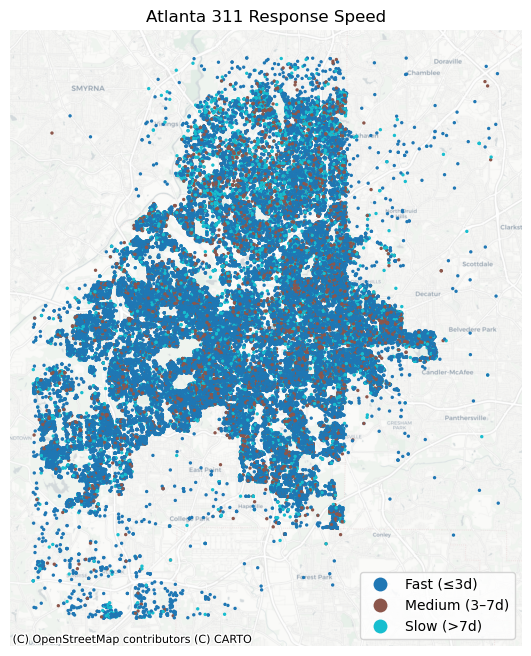

In [70]:
# Categorize response speed
gdf["response_class"] = pd.cut(
    gdf["resolution_time_hours"],
    bins=[0, 72, 168, 10_000],
    labels=["Fast (≤3d)", "Medium (3–7d)", "Slow (>7d)"]
)

fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(
    column="response_class",
    ax=ax,
    markersize=2,
    legend=True
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Atlanta 311 Response Speed" \
"")
ax.axis("off")
plt.show()


In [15]:
gdf["response_class"] = pd.cut(
    gdf["resolution_time_hours"],
    bins=[0, 72, 168, 10_000],
    labels=["Fast (≤3d)", "Medium (3–7d)", "Slow (>7d)"]
)

response_score_map = {
    "Fast (≤3d)": 0.0,
    "Medium (3–7d)": 0.5,
    "Slow (>7d)": 1.0
}

gdf["response_score"] = (
    gdf["response_class"]
    .map(response_score_map)
    .astype(float)
)


In [16]:
# Create spatial grid
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

# grid = (
#     gdf
#     .groupby([pd.cut(gdf["x"], 50), pd.cut(gdf["y"], 50)])
#     .agg(
#         request_count=("resolution_time_hours", "count"),
#         slow_rate=("resolution_time_hours", lambda x: (x > 168).mean())
#     )
#     .reset_index()
# )


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# -----------------------------
# 1. Read cleaned geocoded CSV
# -----------------------------
df = pd.read_csv(
    "../data/cleaned_data/cleaned_ATL311_all_requests2024.csv",
    parse_dates=["Opened", "Closed Date 1", "Closed Date 2", "closed"],
    low_memory=False
)

# -----------------------------
# 3. Create status categories
# -----------------------------
# Assuming "Status" column contains "Resolved" for closed cases
df['is_resolved'] = df['Status'].str.strip().str.lower() == 'resolved'
df['is_active'] = ~df['is_resolved']

# Count active vs resolved
active_count = df['is_active'].sum()
resolved_count = df['is_resolved'].sum()
total_count = len(df)
backlog_rate = active_count / total_count if total_count > 0 else 0

print(f"Active requests: {active_count:,}")
print(f"Resolved requests: {resolved_count:,}")
print(f"Total requests: {total_count:,}")
print(f"Backlog rate: {backlog_rate:.2%}")


In [17]:
grid = (
    gdf
    .groupby([pd.cut(gdf["x"], 50), pd.cut(gdf["y"], 50)])
    .agg(
        request_count=("resolution_time_hours", "count"),

        sla_violation_rate=(
            "resolution_time_hours",
            lambda x: (x > 168).mean()
        ),

        sla_met_rate=(
            "resolution_time_hours",
            lambda x: (x <= 168).mean()
        ),
        response_time_score=("response_score", "mean")

    )
    .reset_index()
)


C:\Users\shrey\AppData\Local\Temp\ipykernel_1036\3158868182.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.cut(gdf["x"], 50), pd.cut(gdf["y"], 50)])


In [20]:
grid["weighted_response_score"] = (
    grid["response_time_score"] *
    np.log1p(grid["request_count"])
)


In [18]:
import numpy as np

In [ ]:
# -----------------------------
# 4. Create GeoDataFrame
# -----------------------------
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lng"], df["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Define pastel/muted colors
color_active = "#f45423"      # muted red/salmon
color_resolved = '#85c1e2'    # soft blue
color_all = '#b19cd9'         # soft purple

# -----------------------------
# Plot 1: Map of all requests
# -----------------------------
fig1, ax1 = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax1,
    markersize=1,
    alpha=0.25,
    color=color_all
)
ctx.add_basemap(
    ax1,
    source=ctx.providers.CartoDB.Positron,
    zoom=12 
)
ax1.set_title("Atlanta 311 All Requests", fontsize=16, fontweight='bold')
ax1.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: Map by status (Active vs Resolved)
# -----------------------------
fig2, ax2 = plt.subplots(figsize=(10, 10))
gdf[gdf['is_resolved']].plot(
    ax=ax2,
    markersize=1,
    alpha=0.3,
    color=color_resolved,
    label='Resolved'
)
gdf[gdf['is_active']].plot(
    ax=ax2,
    markersize=1.5,
    alpha=0.5,
    color=color_active,
    label='Active'
)
ctx.add_basemap(
    ax2,
    source=ctx.providers.CartoDB.Positron,
    zoom=12 
)
ax2.set_title("Active vs Resolved Requests", fontsize=16, fontweight='bold')
ax2.legend(markerscale=6, fontsize=12)
ax2.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 3: Bar chart of Active vs Resolved
# -----------------------------
fig3, ax3 = plt.subplots(figsize=(10, 7))
categories = ['Active', 'Resolved']
counts = [active_count, resolved_count]
colors = [color_active, color_resolved]

bars = ax3.bar(categories, counts, color=colors, alpha=0.8, edgecolor='#5a5a5a', linewidth=1.5)
ax3.set_ylabel('Number of Requests', fontsize=14)
ax3.set_title('Active vs Resolved Requests', fontsize=16, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}',
             ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# -----------------------------
# Plot 4: Backlog Rate Over Time
# -----------------------------
df['opened_date'] = df['Opened'].dt.date
daily_stats = df.groupby('opened_date').agg({
    'is_active': 'sum',
    'is_resolved': 'sum'
}).reset_index()

daily_stats['total'] = daily_stats['is_active'] + daily_stats['is_resolved']
daily_stats['backlog_rate'] = daily_stats['is_active'] / daily_stats['total']

fig4, ax4 = plt.subplots(figsize=(14, 7))
ax4.plot(daily_stats['opened_date'], daily_stats['backlog_rate'], 
         color='#e07a5f', linewidth=2.5, marker='o', markersize=4, alpha=0.8)
ax4.axhline(y=backlog_rate, color='#81b29a', linestyle='--', linewidth=2,
            label=f'Overall Backlog Rate: {backlog_rate:.4f}')
ax4.set_xlabel('Date', fontsize=14)
ax4.set_ylabel('Backlog Rate (Active / Total)', fontsize=14)
ax4.set_title('Daily Backlog Rate Trend', fontsize=16, fontweight='bold')
ax4.legend(fontsize=12)
ax4.grid(alpha=0.3, linestyle='--')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 5: Stacked area chart (Active vs Resolved over time)
# -----------------------------
fig5, ax5 = plt.subplots(figsize=(14, 7))
ax5.fill_between(daily_stats['opened_date'], 0, daily_stats['is_active'], 
                  label='Active', color=color_active, alpha=0.7)
ax5.fill_between(daily_stats['opened_date'], daily_stats['is_active'], 
                  daily_stats['is_active'] + daily_stats['is_resolved'],
                  label='Resolved', color=color_resolved, alpha=0.7)
ax5.set_xlabel('Date', fontsize=14)
ax5.set_ylabel('Number of Requests', fontsize=14)
ax5.set_title('Daily Active vs Resolved Requests', fontsize=16, fontweight='bold')
ax5.legend(fontsize=12)
ax5.grid(alpha=0.3, linestyle='--')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
(grid["sla_violation_rate"] + grid["sla_met_rate"]).describe()


count    1168.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [21]:
# Use bin midpoints as cell centers
grid["x_mid"] = grid.iloc[:, 0].apply(lambda b: b.mid)
grid["y_mid"] = grid.iloc[:, 1].apply(lambda b: b.mid)

grid_gdf = gpd.GeoDataFrame(
    grid,
    geometry=gpd.points_from_xy(grid["x_mid"], grid["y_mid"]),
    crs="EPSG:3857"
)


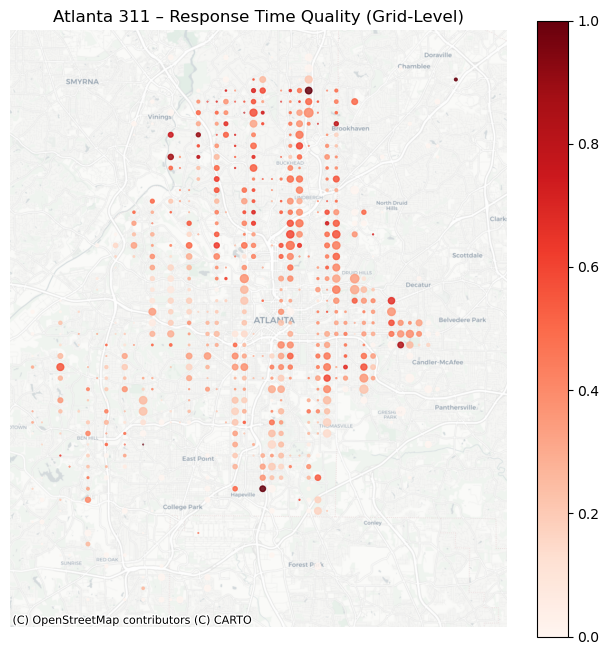

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

grid_gdf.plot(
    column="response_time_score",
    ax=ax,
    markersize=grid_gdf["request_count"] / 5,
    legend=True,
    alpha=0.85,
    cmap="Reds"
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Atlanta 311 – Response Time Quality (Grid-Level)")
ax.axis("off")
plt.show()


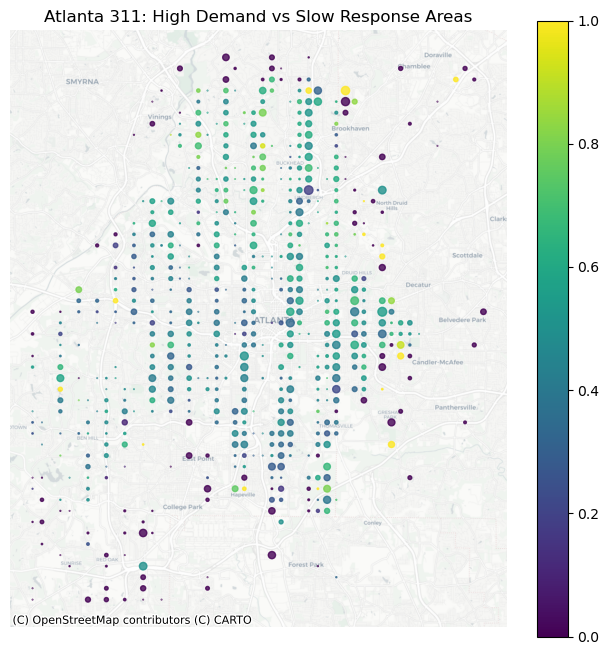

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

grid_gdf.plot(
    column="sla_violation_rate",
    ax=ax,
    markersize=grid_gdf["request_count"] / 5,  # size = demand
    legend=True,
    alpha=0.8
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Atlanta 311: High Demand vs Slow Response Areas")
ax.axis("off")
plt.show()


In [24]:
# Normalize request counts
grid_gdf["norm_service_burden"] = (
    grid_gdf["request_count"] / grid_gdf["request_count"].max()
)

# Quick sanity check
grid_gdf["norm_service_burden"].describe()


count    2500.000000
mean        0.079024
std         0.142132
min         0.000000
25%         0.000000
50%         0.000000
75%         0.104247
max         1.000000
Name: norm_service_burden, dtype: float64

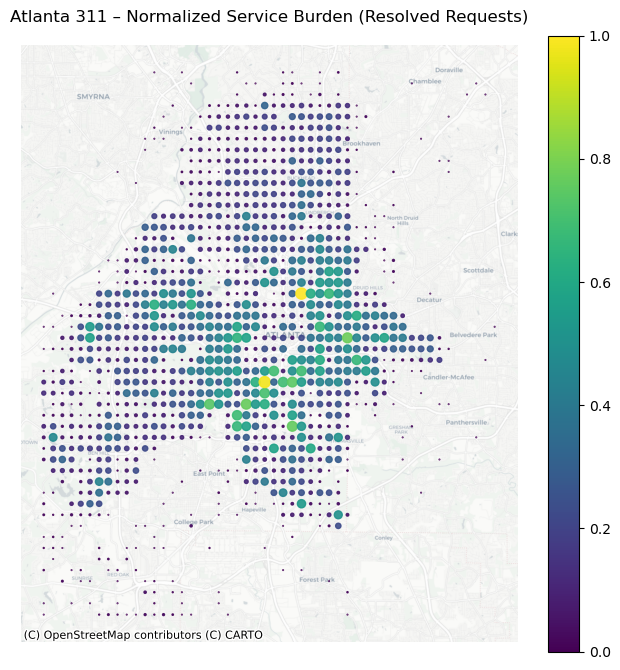

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

grid_gdf.plot(
    column="norm_service_burden",
    ax=ax,
    markersize=grid_gdf["request_count"] / 4,
    legend=True,
    alpha=0.9
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Atlanta 311 – Normalized Service Burden (Resolved Requests)")
ax.axis("off")
plt.show()


In [129]:
grid_gdf.sort_values(
    "norm_service_burden",
    ascending=False
).head(10)[
    ["request_count", "norm_service_burden"]
]


request_count  norm_service_burden
1429            455             1.000000
1421            417             0.916484
1272            399             0.876923
1220            372             0.817582
1125            360             0.791209
1479            356             0.782418
1221            351             0.771429
1119            336             0.738462
1579            332             0.729670
1527            330             0.725275

In [130]:
# Get centroids (still in EPSG:3857)
grid_gdf["centroid"] = grid_gdf.geometry.centroid

# Convert to lat/lon for readability
centroids_ll = grid_gdf.set_geometry("centroid").to_crs(epsg=4326)

grid_gdf["lat"] = centroids_ll.geometry.y
grid_gdf["lon"] = centroids_ll.geometry.x


In [131]:
top_burden = grid_gdf.sort_values(
    "norm_service_burden", ascending=False
).head(10)

top_burden[
    ["request_count", "norm_service_burden", "lat", "lon"]
]



request_count  norm_service_burden        lat        lon
1429            455             1.000000  33.777131 -84.379297
1421            417             0.916484  33.729152 -84.379297
1272            399             0.876923  33.735150 -84.397265
1220            372             0.817582  33.723152 -84.403255
1125            360             0.791209  33.753145 -84.415234
1479            356             0.782418  33.777131 -84.373308
1221            351             0.771429  33.729152 -84.403255
1119            336             0.738462  33.717153 -84.415234
1579            332             0.729670  33.777131 -84.361329
1527            330             0.725275  33.765139 -84.367318

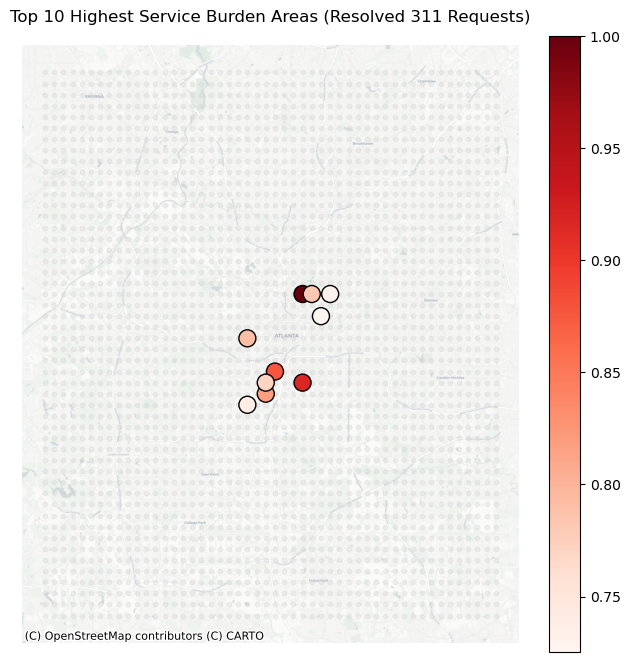

In [132]:
# Top burden cells only
top_cells = grid_gdf.sort_values(
    "norm_service_burden", ascending=False
).head(10)

fig, ax = plt.subplots(figsize=(8, 8))

# Plot full grid lightly
grid_gdf.plot(
    ax=ax,
    color="lightgrey",
    alpha=0.3,
    markersize=10
)

# Highlight top burden cells
top_cells.plot(
    ax=ax,
    column="norm_service_burden",
    cmap="Reds",
    markersize=150,
    edgecolor="black",
    legend=True
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=13
)

ax.set_title("Top 10 Highest Service Burden Areas (Resolved 311 Requests)")
ax.axis("off")

plt.show()


In [133]:
grid_gdf["burden_level"] = pd.qcut(
    grid_gdf["norm_service_burden"],
    q=[0, 0.5, 0.8, 0.95, 1.0],
    labels=["Low", "Moderate", "High", "Very High"]
)


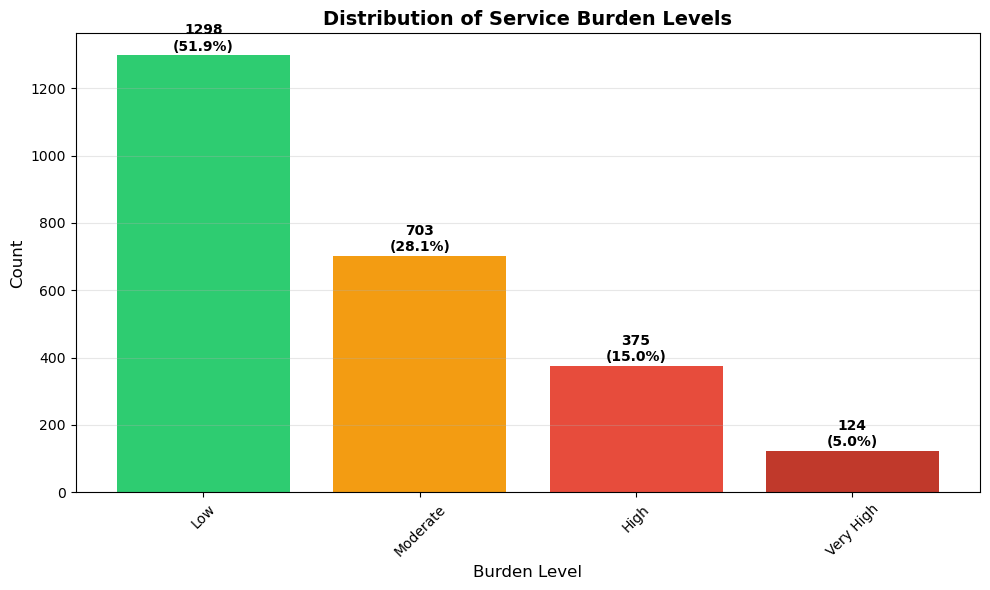


Burden Level Distribution:
burden_level
Low          1298
Moderate      703
High          375
Very High     124
Name: count, dtype: int64

Total areas: 2500

Percentage distribution:
burden_level
Low          51.92
Moderate     28.12
High         15.00
Very High     4.96
Name: count, dtype: float64


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(10, 6))
counts = grid_gdf["burden_level"].value_counts().sort_index()
bars = ax.bar(range(len(counts)), counts.values, 
              color=['#2ecc71', '#f39c12', '#e74c3c', '#c0392b'])

# Add percentage labels on top of bars
total = counts.sum()
for i, (bar, count) in enumerate(zip(bars, counts.values)):
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, rotation=45)
ax.set_title('Distribution of Service Burden Levels', fontsize=14, fontweight='bold')
ax.set_xlabel('Burden Level', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBurden Level Distribution:")
print(burden_counts)
print(f"\nTotal areas: {burden_counts.sum()}")
print("\nPercentage distribution:")
print((burden_counts / burden_counts.sum() * 100).round(2))

In [112]:
grid_gdf["stress_score"] = (
    0.6 * grid_gdf["norm_service_burden"] +
    0.4 * grid_gdf["sla_violation_rate"]
)


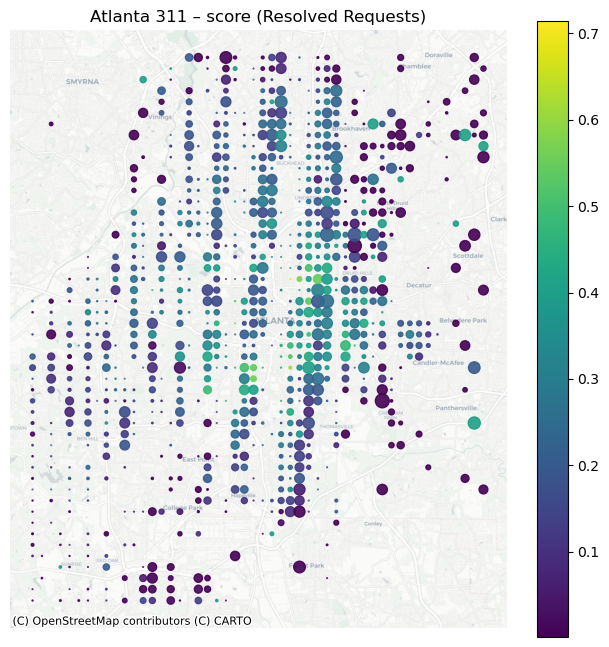

In [117]:
fig, ax = plt.subplots(figsize=(8, 8))

grid_gdf.plot(
    column="stress_score",
    ax=ax,
    markersize=grid_gdf["request_count"] / 4,
    legend=True,
    alpha=0.9
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=12
)

ax.set_title("Atlanta 311 – score (Resolved Requests)")
ax.axis("off")
plt.show()
